In [98]:
import tensorflow as tf

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [100]:
from pathlib import Path

In [101]:
def check_extension(img_path:str) -> bool:
    valid = False
    ext = img_path.split('.')[-1]
    if ext in ['jpg', 'jpeg', 'bmp', 'png', 'JPG', 'PNG', 'JPEG', 'BMP']:
        valid = True
    return valid

In [102]:
DATA_DIR = Path('/content/sample_data/dataset')
EPOCHS = 50
BATCHES = 32
IMAGE_SIZE = 256
CHANNEL = 3

In [103]:
for img_cls in os.listdir(DATA_DIR):
    for img in os.listdir(os.path.join(DATA_DIR, Path(img_cls))):
        img_path = os.path.join(DATA_DIR, Path(img_cls), Path(img))
        try:
            img = cv2.imread(img_path)
            if not check_extension(img_path):
                print(f'Image not in expected format: {img_path}')
                os.remove(Path(img_path))
        except Exception as e:
            print(f'Issue with image: {img_path}')

In [104]:
data = tf.keras.utils.image_dataset_from_directory(DATA_DIR)

Found 2152 files belonging to 3 classes.


In [105]:
class_names = data.class_names

In [106]:
class_names
n_classes = len(class_names)

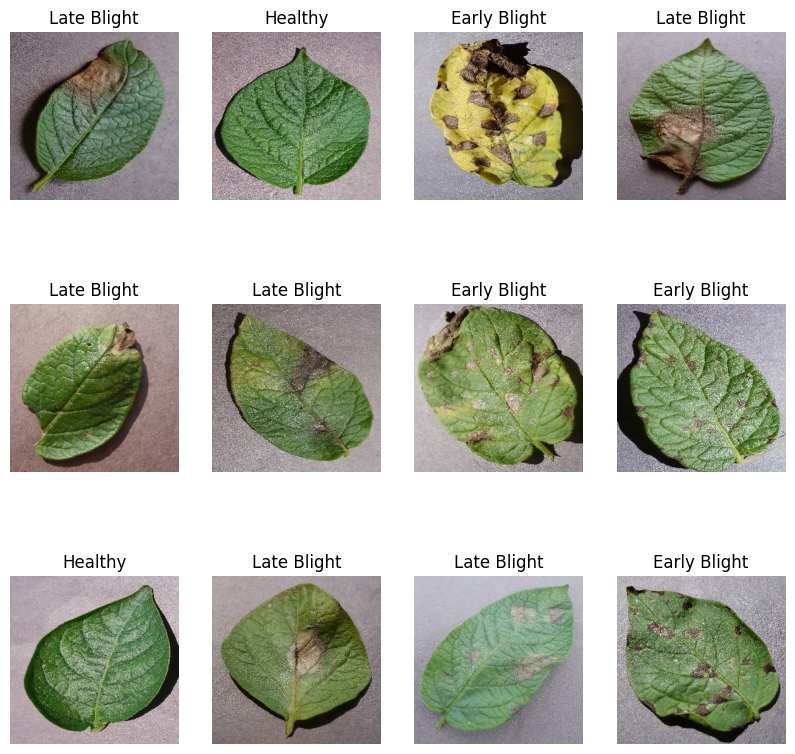

In [107]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [108]:
def get_data_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert train_split + val_split + test_split == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=44)

    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    test_size = int(ds_size * test_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [109]:
train_ds, val_ds, test_ds = get_data_partitions(data)

In [110]:
len(data), len(train_ds), len(val_ds), len(test_ds)

(68, 54, 6, 8)

In [111]:
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [112]:
# resize_and_rescale = tf.keras.Sequential([
#   layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#   layers.experimental.preprocessing.Rescaling(1./255),
# ])

In [113]:
resize_and_rescale = tf.keras.models.Sequential()

resize_and_rescale.add(tf.keras.layers.Resizing(256, 256))
resize_and_rescale.add(tf.keras.layers.Rescaling(scale=1./255))

In [114]:
data_augmentation = tf.keras.models.Sequential()

data_augmentation.add(tf.keras.layers.RandomFlip())
data_augmentation.add(tf.keras.layers.RandomRotation(0.2))

In [115]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [116]:
# n_classes = 3
INPUT_SHAPE = (BATCHES, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)

In [117]:
model = tf.keras.models.Sequential()

model.add(resize_and_rescale)
# model.add(tf.keras.layers.Input(shape=INPUT_SHAPE))

model.add(tf.keras.layers.Conv2D(128, (3, 3), 1, activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, (3, 3), 1, activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(32, (3, 3), 1, activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(16, (3, 3), 1, activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation = "relu"))
model.add(tf.keras.layers.Dense(n_classes, activation = "softmax"))


In [118]:
model.build(input_shape=INPUT_SHAPE)

In [119]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 254, 254, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 127, 127, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 125, 125, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 60, 60, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 30, 30, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (32, 28, 28, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (32, 14, 14, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (32, 3136)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 64)                    │         200,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 301,427 (1.15 MB)

 Trainable params: 301,427 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
# es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights = True)

In [121]:
model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [122]:
# hist = model.fit(train_ds, batch_size=32, validation_data = val_ds, epochs=20, callbacks=[es])
hist = model.fit(train_ds, batch_size=32, validation_data = val_ds, epochs=50)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 639ms/step - accuracy: 0.4729 - loss: 0.9232 - val_accuracy: 0.7240 - val_loss: 0.6621
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.7749 - loss: 0.5902 - val_accuracy: 0.7604 - val_loss: 0.4921
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.8611 - loss: 0.3552 - val_accuracy: 0.7656 - val_loss: 0.4864
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 391ms/step - accuracy: 0.8736 - loss: 0.3190 - val_accuracy: 0.8802 - val_loss: 0.2603
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.9158 - loss: 0.2211 - val_accuracy: 0.8646 - val_loss: 0.2599
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.9045 - loss: 0.2342 - val_accuracy: 0.9688 - val_loss: 0.1166
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 389ms/step - accuracy: 0.9177 - loss: 0.2025 - val_accuracy: 0.9062 - val_loss: 0.2148
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 422ms/step - accuracy: 0.9328 - loss: 0.1799 - val_accu

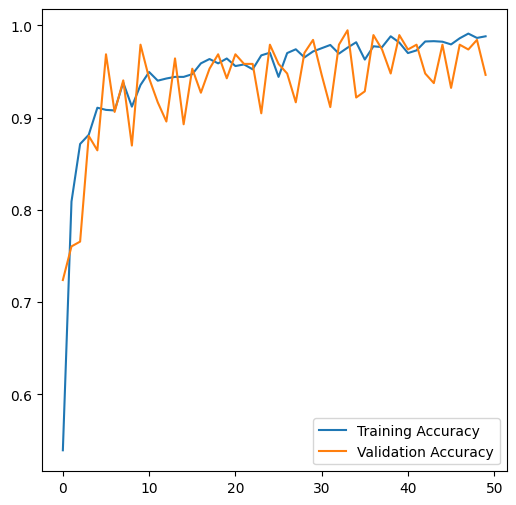

In [123]:
plt.figure(figsize=(6, 6))

plt.plot(hist.history['accuracy'], label="Training Accuracy")
plt.plot(hist.history['val_accuracy'], label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.show()

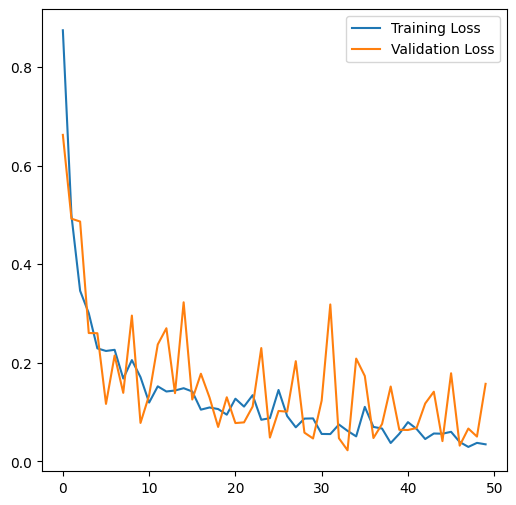

In [124]:
plt.figure(figsize=(6, 6))

plt.plot(hist.history['loss'], label="Training Loss")
plt.plot(hist.history['val_loss'], label = "Validation Loss")
plt.legend(loc="best")
plt.show()

In [125]:
score = model.evaluate(test_ds)
score

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9660 - loss: 0.0710


[0.058105699717998505, 0.9765625]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


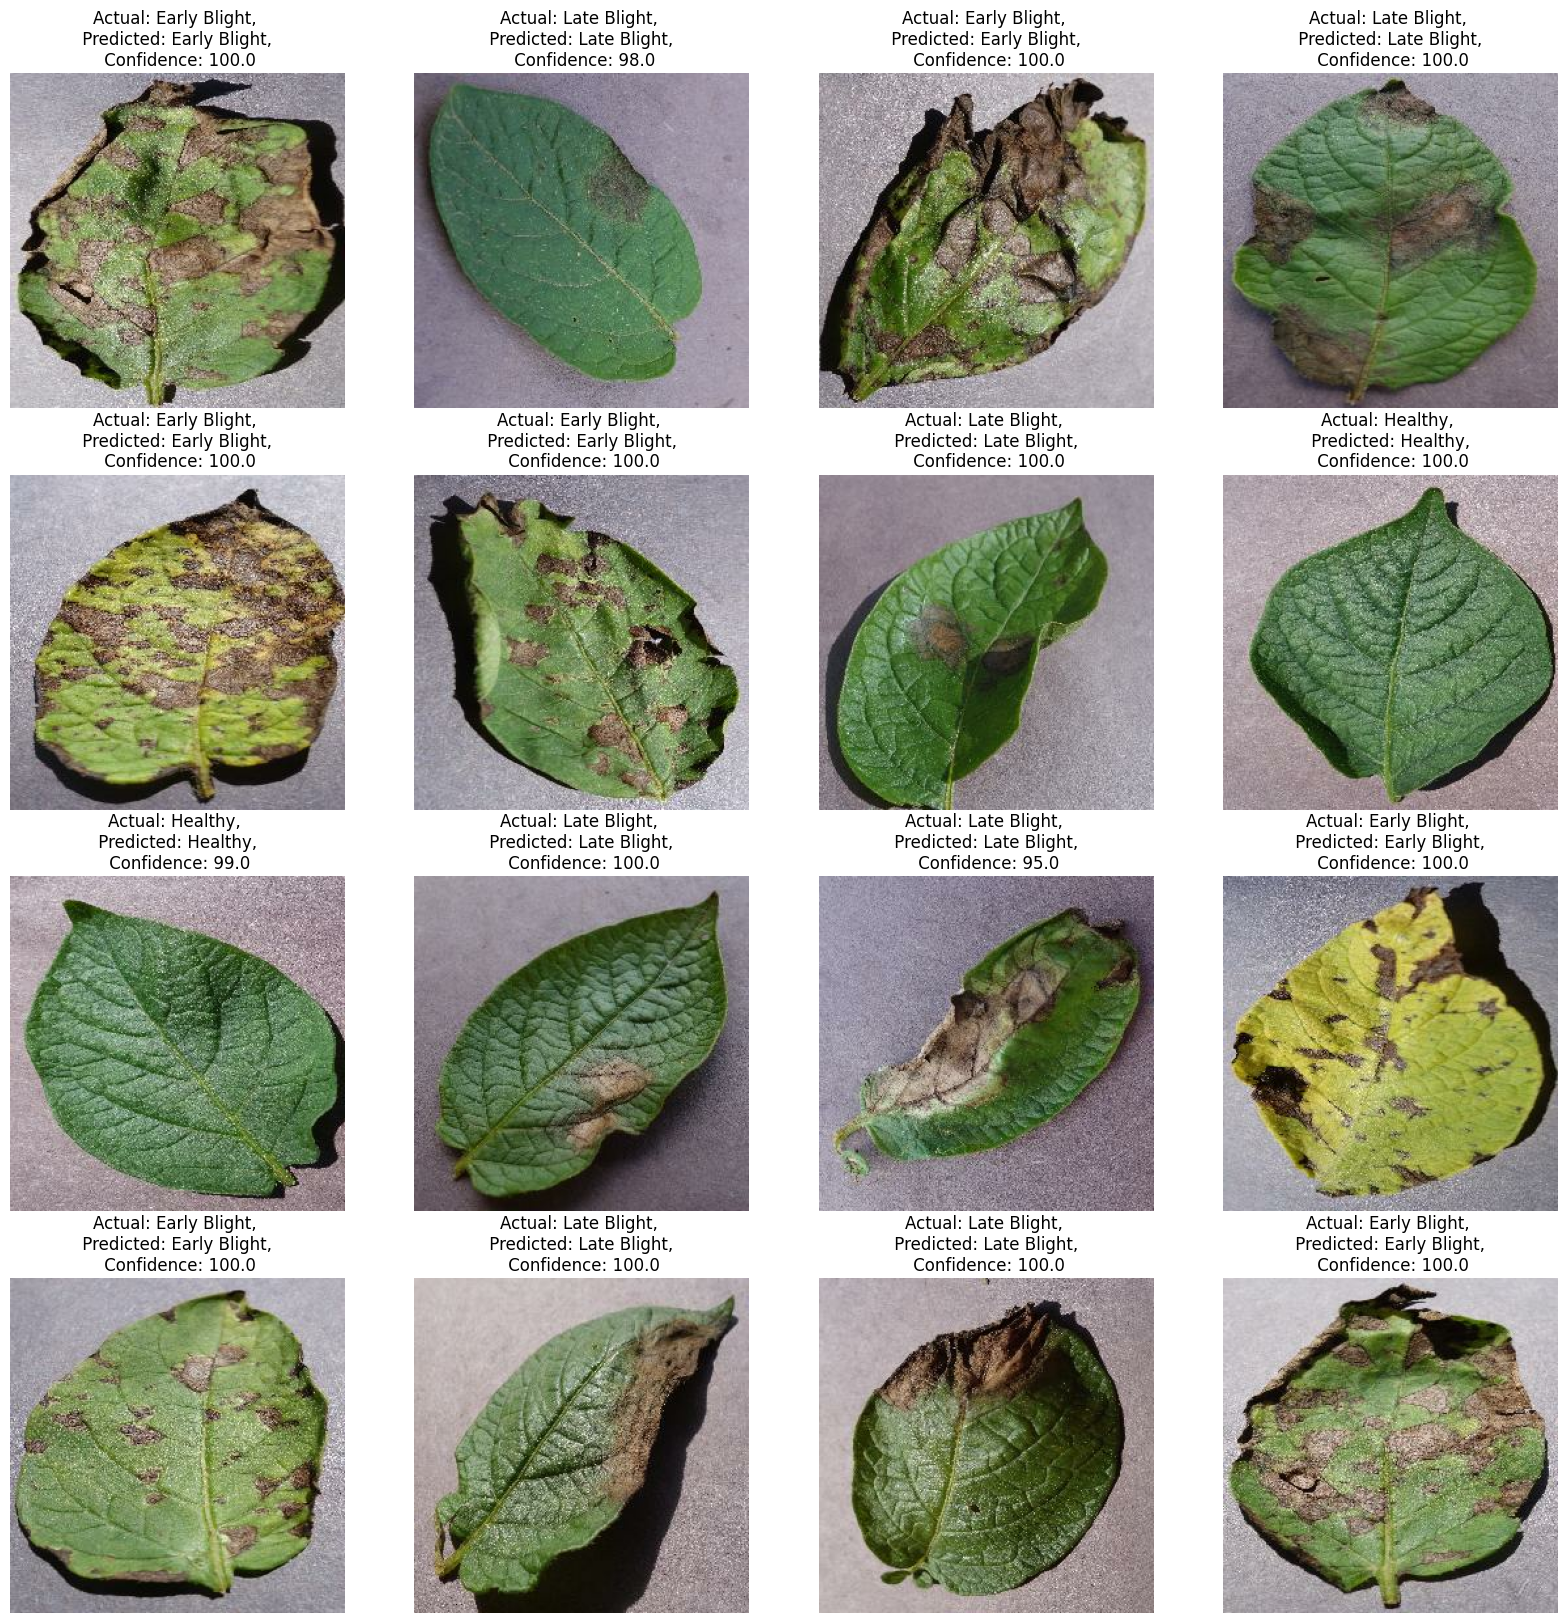

In [126]:
plt.figure(figsize=(20, 20))

for image, label in test_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image[i].numpy().astype(int))

    img_arr = np.expand_dims(image[i], axis=0)
    probabilities = model.predict(img_arr)
    prediction = class_names[np.argmax(probabilities[0])]
    confidence = round(100 * np.max(probabilities[0]), 2)
    actual = class_names[label[i]]
    plt.title(f"Actual: {actual}, \n Predicted: {prediction}, \n Confidence: {confidence}")
    plt.axis("off")

In [128]:
model.save(f"/content/models/model_v_1.keras")